In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score,balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score



In [4]:
df = pd.read_csv('processedData.csv', index_col=[0])
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single
0,5,261,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,5,149,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,3,226,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,3,151,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,5,307,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,334,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41184,4,383,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41185,5,189,2,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41186,4,442,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0


In [5]:
def converty(x):
    if x=='yes':
        return 1
    return 0

y = df['y']
y = y.apply(converty)
X = df.drop(columns=['y'])


In [6]:
df.shape

(41173, 58)

In [7]:
y.value_counts()

0    36543
1     4630
Name: y, dtype: int64

### Splitting dataset with stratification

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)


In [9]:
X_train.shape

(32938, 57)

In [10]:
y_test.value_counts()

0    7303
1     932
Name: y, dtype: int64

### SMOTE oversampled data

In [11]:
# Create an oversampled training data
smote = SMOTE(random_state = 17)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

### Classification Report Plot function

In [12]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            txt = matrix[row][column]
            ax.text(column,row,matrix[row][column],va='center',ha='center')

    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

### ROC Curve Plot function

In [13]:
def ROC_function(model,X_test,y_test):
    noskill_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    prob = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    prob = prob[:, 1]
    # calculate scores
    noskill_auc = roc_auc_score(y_test, noskill_probs)
    auc = roc_auc_score(y_test, prob)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (noskill_auc))
    print('RF: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    noskill_fpr, noskill_tpr, _ = roc_curve(y_test, noskill_probs)
    fpr, tpr, _ = roc_curve(y_test, prob)
    # plot the roc curve for the model
    plt.figure(figsize=(16,8))
    plt.plot(noskill_fpr, noskill_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='RF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

***
## Logistic Regression

### Logistic Regression on Imbalanced Data 

In [14]:
#Training with imbalance data
lr_model = LogisticRegression(solver='lbfgs', max_iter=500)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [15]:
y_pred = lr_model.predict(X_test)

In [16]:
lr_classification_report = classification_report(y_test, y_pred)
print(lr_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.63      0.41      0.50       932

    accuracy                           0.91      8235
   macro avg       0.78      0.69      0.72      8235
weighted avg       0.89      0.91      0.90      8235



In [17]:
lr_acc = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
lr_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred)*100, 2)

print(f"Accuracy: {lr_acc}%")
print(f"Balanced Accuracy: {lr_bacc}%")


Accuracy: 90.65%
Balanced Accuracy: 69.08%


In [18]:
logr_cm = confusion_matrix(y_test, y_pred)
print(logr_cm)


[[7081  222]
 [ 548  384]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

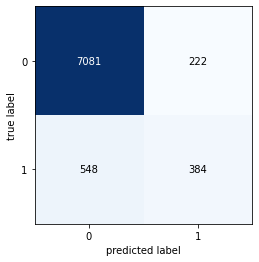

In [19]:
plot_confusion_matrix(logr_cm)

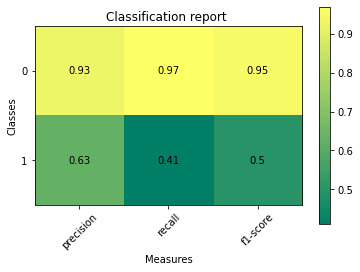

In [20]:
lr_cr = """            precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.63      0.41      0.50       932

    accuracy                           0.91      8235
   macro avg       0.78      0.69      0.72      8235
weighted avg       0.89      0.91      0.90      8235"""

plot_classification_report(lr_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.931


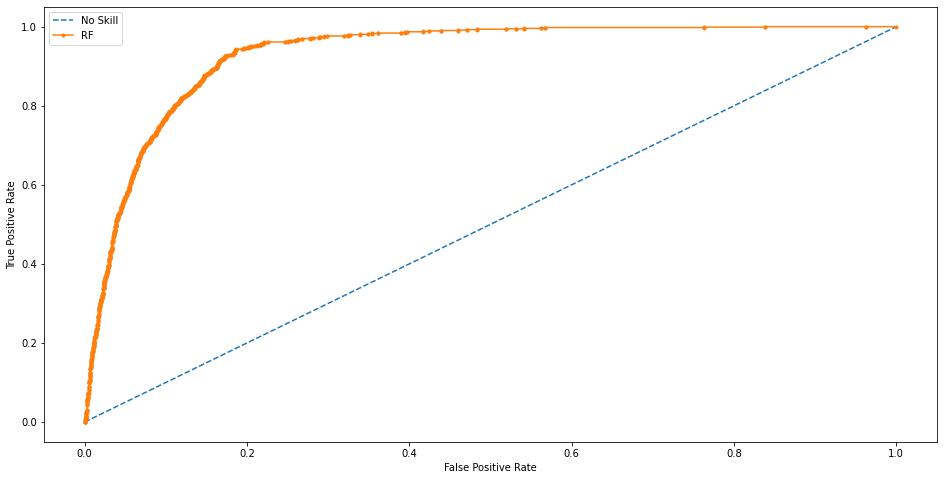

In [21]:
ROC_function(lr_model, X_test, y_test)

In [45]:
lr_f1 = f1_score(y_test, y_pred, average=None) 
lr_f1

array([0.9484329, 0.4993498])

### Logistic Regression on SMOTE oversampled Data

In [22]:
lrsmote_model = LogisticRegression(solver='lbfgs', max_iter=200, random_state=12)
lrsmote_model.fit(X_SMOTE, y_SMOTE)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200, random_state=12)

In [23]:
y_pred_smote = lrsmote_model.predict(X_test)

In [24]:
lrsmote_classification_report = classification_report(y_test, y_pred_smote)
print(lrsmote_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7303
           1       0.55      0.54      0.55       932

    accuracy                           0.90      8235
   macro avg       0.75      0.74      0.75      8235
weighted avg       0.90      0.90      0.90      8235



In [25]:
lr_smote_acc = round(metrics.accuracy_score(y_test, y_pred_smote)*100, 2)
lr_smote_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred_smote)*100, 2)

print(f"Accuracy: {lr_smote_acc}%")
print(f"Balanced Accuracy: {lr_smote_bacc}%")


Accuracy: 89.85%
Balanced Accuracy: 74.39%


In [26]:
lr_smote_cm = confusion_matrix(y_test, y_pred_smote)
print(lr_smote_cm)


[[6892  411]
 [ 425  507]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

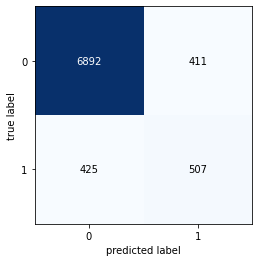

In [27]:
plot_confusion_matrix(lr_smote_cm)

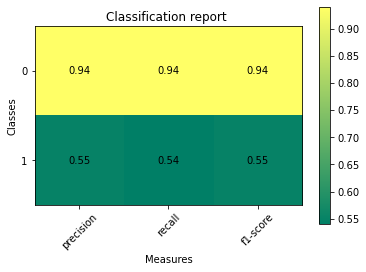

In [28]:
lr_smote_cr = """             precision    recall  f1-score   support

           0       0.94      0.94      0.94      7303
           1       0.55      0.54      0.55       932

    accuracy                           0.90      8235
   macro avg       0.75      0.74      0.75      8235
weighted avg       0.90      0.90      0.90      8235"""

plot_classification_report(lr_smote_cr)

#### ROC Curve:

No Skill: ROC AUC=0.500
RF: ROC AUC=0.919


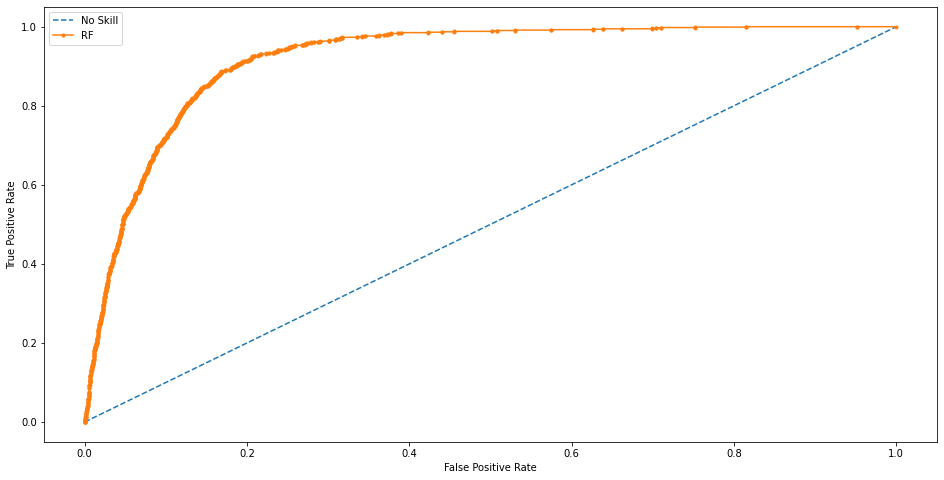

In [29]:
ROC_function(lrsmote_model, X_test, y_test)

In [46]:
lr_smote_f1 = f1_score(y_test, y_pred_smote, average=None) 
lr_smote_f1

array([0.94281806, 0.54810811])

### Parameter tuning for Logistic Regression on SMOTE Data


In [30]:
lr_pt_model = LogisticRegression()
parameters = {'solver': ['liblinear', 'lbfgs',  'saga'],'C':[0.001,0.01,0.1,1,10],'random_state':[12]}

#use gridsearch (4-fold cross validation) 
lr_gscv = GridSearchCV(lr_pt_model, parameters, cv=4, n_jobs=-1)
#fit model to data
lr_gscv.fit(X_SMOTE, y_SMOTE)
print("Best parameters:")
lr_gscv.best_params_

Best parameters:


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 0.1, 'random_state': 12, 'solver': 'lbfgs'}

### Logistic Regression with tuned parameters

In [31]:
lr_bp_model = LogisticRegression(C= 0.1, solver='lbfgs', max_iter=200)
lr_bp_model.fit(X_SMOTE, y_SMOTE)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, max_iter=200)

In [32]:
y_pred_bp = lr_bp_model.predict(X_test)

In [33]:
lr_bp_classification_report = classification_report(y_test, y_pred_bp)
print(lr_bp_classification_report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7303
           1       0.57      0.50      0.53       932

    accuracy                           0.90      8235
   macro avg       0.75      0.72      0.74      8235
weighted avg       0.90      0.90      0.90      8235



In [34]:
lr_bp_acc = round(metrics.accuracy_score(y_test, y_pred_bp)*100, 2)
lr_bp_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred_bp)*100, 2)

print(f"Accuracy: {lr_bp_acc}%")
print(f"Balanced Accuracy: {lr_bp_bacc}%")


Accuracy: 90.12%
Balanced Accuracy: 72.43%


In [35]:
lr_bp_cm = confusion_matrix(y_test, y_pred_bp)
print(lr_bp_cm)


[[6959  344]
 [ 470  462]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

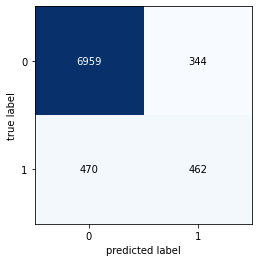

In [36]:
plot_confusion_matrix(lr_bp_cm)

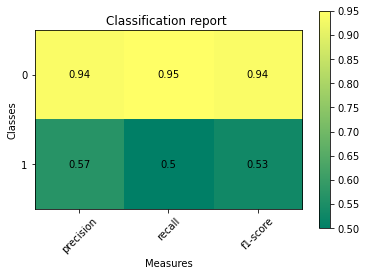

In [38]:
lr_bp_cr = """             precision    recall  f1-score   support

           0       0.94      0.95      0.94      7303
           1       0.57      0.50      0.53       932

    accuracy                           0.90      8235
   macro avg       0.75      0.72      0.74      8235
weighted avg       0.90      0.90      0.90      8235"""

plot_classification_report(lr_bp_cr)

### ROC curve

No Skill: ROC AUC=0.500
RF: ROC AUC=0.915


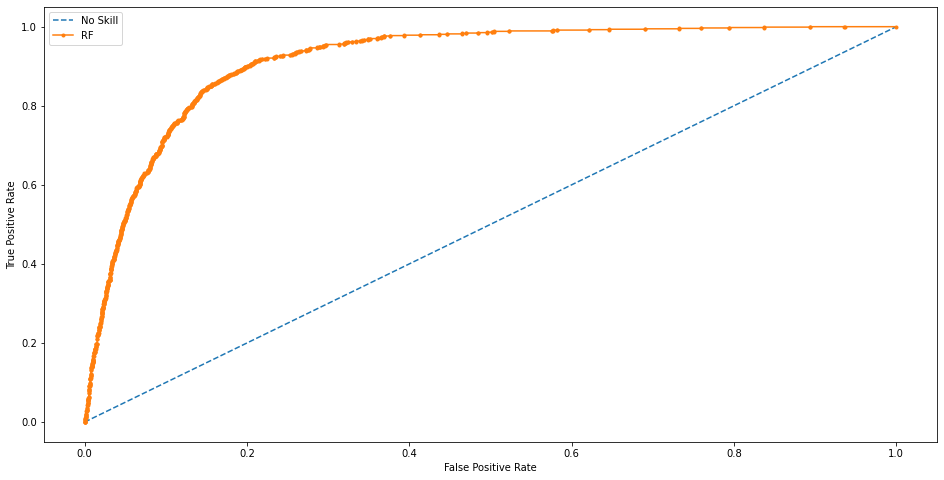

In [37]:
ROC_function(lr_bp_model, X_test, y_test)

In [47]:
lr_bp_f1 = f1_score(y_test, y_pred_bp, average=None) 
lr_bp_f1

array([0.94474613, 0.53164557])

### Models Accuracy

In [48]:
models = ['Logistic Regression: Imbalanced Data', 'Logistic Regression: SMOTE Data', 'Logistic Regression: SMOTE Tuned Parameters']
accuracies = [lr_acc, lr_smote_acc, lr_bp_acc]
balancedAccuracies = [lr_bacc, lr_smote_bacc, lr_bp_bacc]
f1_scores = [lr_f1[1], lr_smote_f1[1], lr_bp_f1[1]]


modelsInfo = {'Models': models, 'Accuracy': accuracies, 'Balanced Accuracy': balancedAccuracies, 'f1-Scores': f1_scores}
modelsDf = pd.DataFrame(modelsInfo)
modelsDf

,Models,Accuracy,Balanced Accuracy,f1-Scores
0,Logistic Regression: Imbalanced Data,90.65,69.08,0.499350
1,Logistic Regression: SMOTE Data,89.85,74.39,0.548108
2,Logistic Regression: SMOTE Tuned Parameters,90.12,72.43,0.531646


### Models Performance Comparison

Text(0.5, 1.0, 'Accuracies vs Balanced Accuracies')

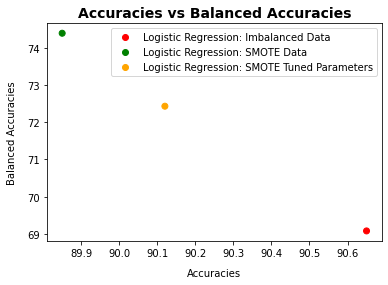

In [42]:
x = modelsDf['Accuracy']
y = modelsDf['Balanced Accuracy']
classes = list(modelsDf['Models'])
values = [0, 1, 2]
colours = ListedColormap(['red','brown','cyan', 'green', 'blue', 'orange'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.xlabel('Accuracies', labelpad=10)
plt.ylabel('Balanced Accuracies', labelpad=10)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Accuracies vs Balanced Accuracies', fontweight='bold', size=14)

Text(0.5, 1.0, 'f1-Scores vs Balanced Accuracies')

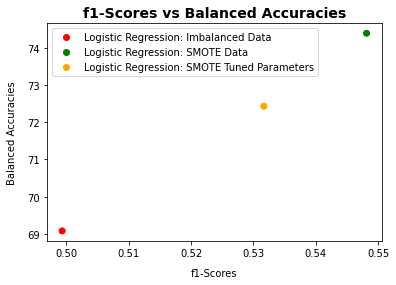

In [49]:
x = modelsDf['f1-Scores']
y = modelsDf['Balanced Accuracy']
classes = list(modelsDf['Models'])
values = [0, 1, 2]
colours = ListedColormap(['red','brown','cyan', 'green', 'blue', 'orange'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.xlabel('f1-Scores', labelpad=10)
plt.ylabel('Balanced Accuracies', labelpad=10)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('f1-Scores vs Balanced Accuracies', fontweight='bold', size=14)

### Feature Importance from Best Model

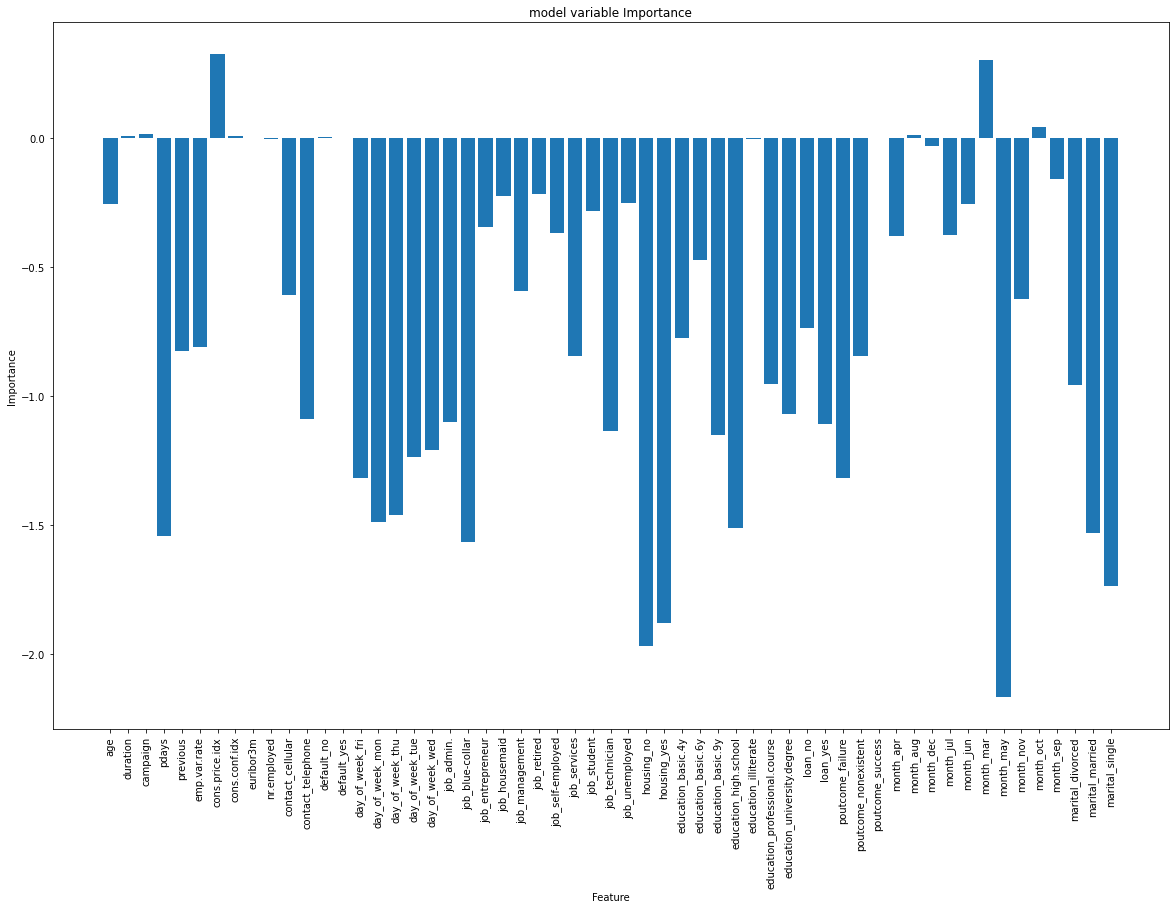

In [50]:
importance = lrsmote_model.coef_[0]
plt.figure(figsize=(20,13))
plt.bar(X_SMOTE.columns, importance)
plt.xticks(rotation='vertical')
plt.title('model variable Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

## References 

* https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50
* https://medium.com/@oluwabukunmige/logistic-regression-in-scikit-learn-a-step-by-step-process-32f546241f32
* http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
* https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/